<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


In [770]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

## A. Checking and Preprocessing

In [771]:
import pandas as pd

df = pd.read_csv('./nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


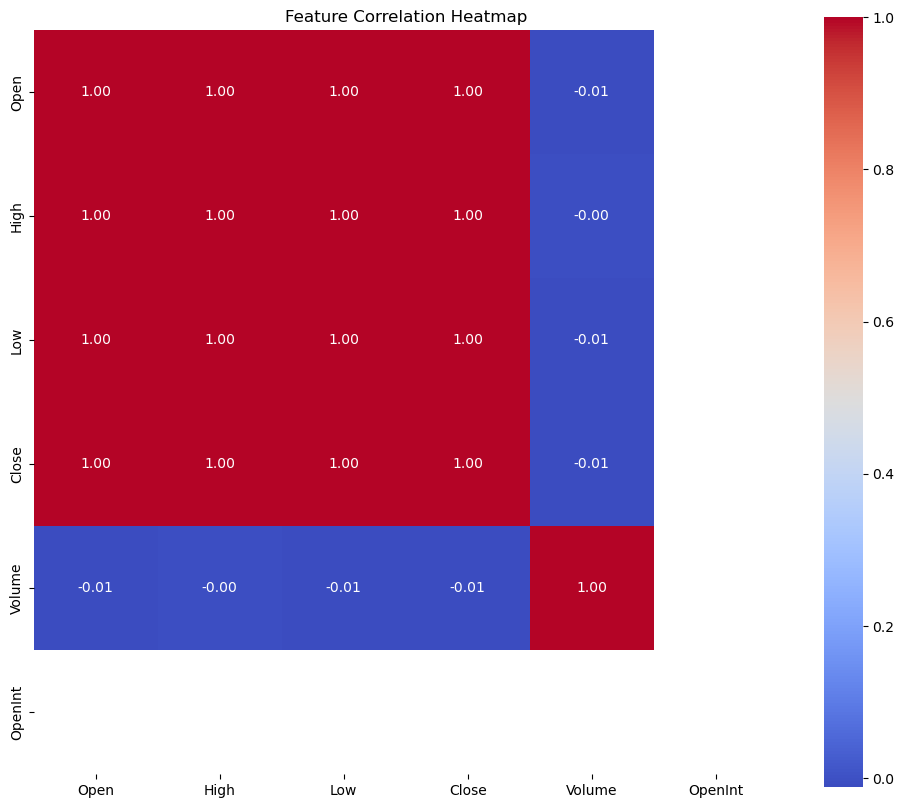

In [772]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.drop(['Date'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

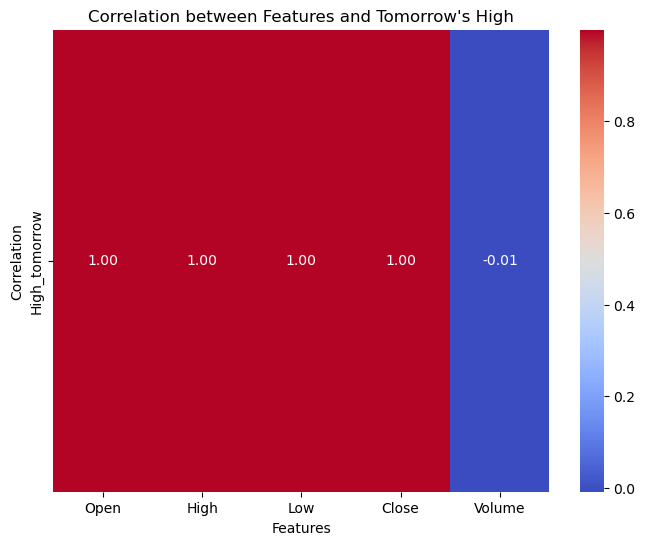

In [773]:

df['High_tomorrow'] = df['High'].shift(-1)

selected_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  
corr_with_high_tomorrow = df[selected_cols + ['High_tomorrow']].corr()

corr_target = corr_with_high_tomorrow['High_tomorrow'].drop('High_tomorrow')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_target.to_frame().T, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation between Features and Tomorrow\'s High')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()



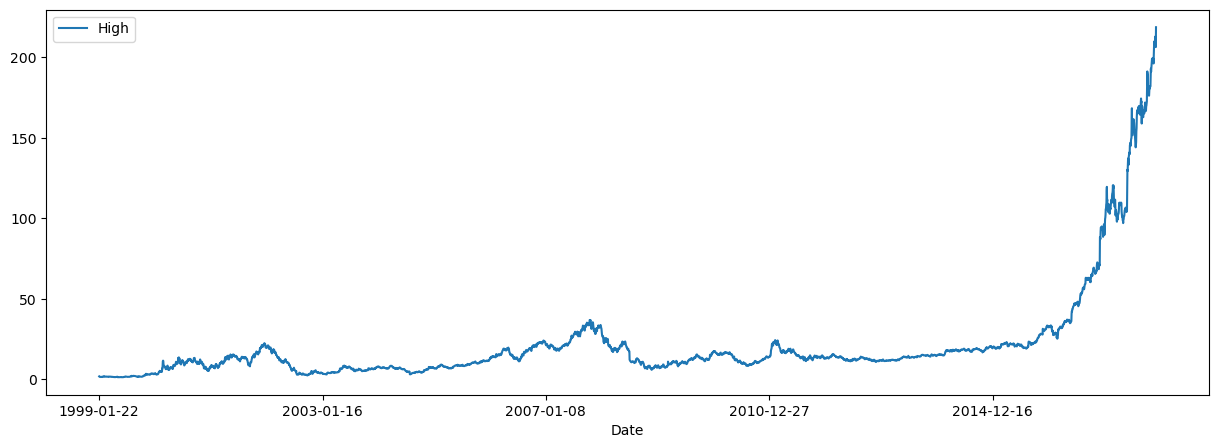

In [754]:
plot = df.plot('Date', 'High', figsize=(15, 5))

In [755]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [757]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [758]:
df = df.dropna()

In [759]:
df.shape

(4733, 7)

In [760]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [761]:
def create_sequences(input_data, output_data, window_size, step):
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [762]:
# Select features
features_col = ['Open', 'High', 'Low', 'Close']
features = df[features_col]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=10, step=7)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

######################################################### normalized
from sklearn.preprocessing import StandardScaler
num_samples, window_size, num_features = x_train.shape

scaler = StandardScaler()
x_train_flat = x_train.reshape(-1, num_features)
x_val_flat = x_val.reshape(-1, num_features)
x_test_flat = x_test.reshape(-1, num_features)

# Fit scaler only on training data
scaler.fit(x_train_flat)

# Transform
x_train = scaler.transform(x_train_flat).reshape(num_samples, window_size, num_features)

num_samples_val = x_val.shape[0]
x_val = scaler.transform(x_val_flat).reshape(num_samples_val, window_size, num_features)

num_samples_test = x_test.shape[0]
x_test = scaler.transform(x_test_flat).reshape(num_samples_test, window_size, num_features)
#############################################################

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Shape of data X: (675, 10, 4)
Shape of data y: (675,)
Shape of data x_train: (486, 10, 4)
Shape of data y_train: (486,)
Shape of data x_val: (122, 10, 4)
Shape of data y_val: (122,)
Shape of data x_test: (67, 10, 4)
Shape of data y_test: (67,)
Number of samples in training and validation are 486 and 122.


## B. Defining Neural Networks

In [763]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [764]:
# Check your GPU status.
# !nvidia-smi

In [765]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=len(features_col), hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

  3%|▎         | 3/100 [00:00<00:12,  8.06it/s]

Epoch 1/100, Train loss: 1107.1578, Val loss: 890.6438, Best Val loss: 890.6438
Epoch 2/100, Train loss: 865.1608, Val loss: 806.3128, Best Val loss: 806.3128
Epoch 3/100, Train loss: 976.7215, Val loss: 764.3661, Best Val loss: 764.3661


  5%|▌         | 5/100 [00:00<00:09,  9.96it/s]

Epoch 4/100, Train loss: 762.8014, Val loss: 719.3960, Best Val loss: 719.3960
Epoch 5/100, Train loss: 755.0401, Val loss: 660.5711, Best Val loss: 660.5711
Epoch 6/100, Train loss: 878.4963, Val loss: 611.7272, Best Val loss: 611.7272


  9%|▉         | 9/100 [00:00<00:07, 12.48it/s]

Epoch 7/100, Train loss: 600.4957, Val loss: 530.6707, Best Val loss: 530.6707
Epoch 8/100, Train loss: 513.1792, Val loss: 465.6987, Best Val loss: 465.6987
Epoch 9/100, Train loss: 435.3075, Val loss: 402.6848, Best Val loss: 402.6848
Epoch 10/100, Train loss: 496.4274, Val loss: 345.5931, Best Val loss: 345.5931


 13%|█▎        | 13/100 [00:01<00:06, 13.80it/s]

Epoch 11/100, Train loss: 321.5912, Val loss: 317.5384, Best Val loss: 317.5384
Epoch 12/100, Train loss: 299.4694, Val loss: 280.7414, Best Val loss: 280.7414
Epoch 13/100, Train loss: 269.3930, Val loss: 256.0107, Best Val loss: 256.0107


 15%|█▌        | 15/100 [00:01<00:06, 14.02it/s]

Epoch 14/100, Train loss: 236.4514, Val loss: 233.4635, Best Val loss: 233.4635
Epoch 15/100, Train loss: 224.1952, Val loss: 215.8128, Best Val loss: 215.8128
Epoch 16/100, Train loss: 223.4470, Val loss: 197.5621, Best Val loss: 197.5621
Epoch 17/100, Train loss: 176.0380, Val loss: 180.0956, Best Val loss: 180.0956


 19%|█▉        | 19/100 [00:01<00:05, 14.19it/s]

Epoch 18/100, Train loss: 159.0082, Val loss: 168.5507, Best Val loss: 168.5507
Epoch 19/100, Train loss: 147.5546, Val loss: 156.9765, Best Val loss: 156.9765
Epoch 20/100, Train loss: 136.2539, Val loss: 150.0102, Best Val loss: 150.0102


 23%|██▎       | 23/100 [00:01<00:05, 14.21it/s]

Epoch 21/100, Train loss: 144.9189, Val loss: 141.5588, Best Val loss: 141.5588
Epoch 22/100, Train loss: 117.6215, Val loss: 129.8408, Best Val loss: 129.8408
Epoch 23/100, Train loss: 138.0753, Val loss: 123.2629, Best Val loss: 123.2629
Epoch 24/100, Train loss: 101.2627, Val loss: 114.2653, Best Val loss: 114.2653


 27%|██▋       | 27/100 [00:02<00:05, 14.59it/s]

Epoch 25/100, Train loss: 96.4941, Val loss: 117.0880, Best Val loss: 114.2653
Epoch 26/100, Train loss: 93.4112, Val loss: 104.0379, Best Val loss: 104.0379
Epoch 27/100, Train loss: 86.0971, Val loss: 98.9015, Best Val loss: 98.9015


 29%|██▉       | 29/100 [00:02<00:04, 14.53it/s]

Epoch 28/100, Train loss: 81.1216, Val loss: 95.7382, Best Val loss: 95.7382
Epoch 29/100, Train loss: 76.0587, Val loss: 87.5343, Best Val loss: 87.5343
Epoch 30/100, Train loss: 70.8628, Val loss: 81.1846, Best Val loss: 81.1846


 33%|███▎      | 33/100 [00:02<00:04, 14.16it/s]

Epoch 31/100, Train loss: 68.3423, Val loss: 77.6350, Best Val loss: 77.6350
Epoch 32/100, Train loss: 64.8727, Val loss: 72.1665, Best Val loss: 72.1665
Epoch 33/100, Train loss: 73.4828, Val loss: 67.9312, Best Val loss: 67.9312


 35%|███▌      | 35/100 [00:02<00:04, 14.29it/s]

Epoch 34/100, Train loss: 57.2409, Val loss: 64.0366, Best Val loss: 64.0366
Epoch 35/100, Train loss: 53.4519, Val loss: 60.7713, Best Val loss: 60.7713
Epoch 36/100, Train loss: 52.2307, Val loss: 57.3521, Best Val loss: 57.3521
Epoch 37/100, Train loss: 51.4041, Val loss: 58.2575, Best Val loss: 57.3521


 39%|███▉      | 39/100 [00:02<00:04, 14.59it/s]

Epoch 38/100, Train loss: 68.1512, Val loss: 54.3396, Best Val loss: 54.3396
Epoch 39/100, Train loss: 96.0233, Val loss: 70.9878, Best Val loss: 54.3396
Epoch 40/100, Train loss: 73.9278, Val loss: 59.0430, Best Val loss: 54.3396
Epoch 41/100, Train loss: 51.1749, Val loss: 51.7815, Best Val loss: 51.7815


 43%|████▎     | 43/100 [00:03<00:03, 14.91it/s]

Epoch 42/100, Train loss: 43.0320, Val loss: 46.1531, Best Val loss: 46.1531
Epoch 43/100, Train loss: 38.3987, Val loss: 43.8384, Best Val loss: 43.8384
Epoch 44/100, Train loss: 39.0932, Val loss: 40.9119, Best Val loss: 40.9119
Epoch 45/100, Train loss: 35.1149, Val loss: 39.3837, Best Val loss: 39.3837


 47%|████▋     | 47/100 [00:03<00:03, 14.71it/s]

Epoch 46/100, Train loss: 32.5472, Val loss: 37.3675, Best Val loss: 37.3675
Epoch 47/100, Train loss: 32.6900, Val loss: 35.7619, Best Val loss: 35.7619
Epoch 48/100, Train loss: 32.1637, Val loss: 34.4495, Best Val loss: 34.4495


 51%|█████     | 51/100 [00:03<00:03, 14.53it/s]

Epoch 49/100, Train loss: 28.8230, Val loss: 32.9278, Best Val loss: 32.9278
Epoch 50/100, Train loss: 27.5731, Val loss: 31.6944, Best Val loss: 31.6944
Epoch 51/100, Train loss: 26.5218, Val loss: 30.4574, Best Val loss: 30.4574


 53%|█████▎    | 53/100 [00:03<00:03, 14.42it/s]

Epoch 52/100, Train loss: 25.6094, Val loss: 29.1663, Best Val loss: 29.1663
Epoch 53/100, Train loss: 24.6143, Val loss: 28.4336, Best Val loss: 28.4336
Epoch 54/100, Train loss: 24.2150, Val loss: 27.3500, Best Val loss: 27.3500


 57%|█████▋    | 57/100 [00:04<00:02, 14.42it/s]

Epoch 55/100, Train loss: 23.2672, Val loss: 26.4115, Best Val loss: 26.4115
Epoch 56/100, Train loss: 23.6032, Val loss: 25.4819, Best Val loss: 25.4819
Epoch 57/100, Train loss: 23.9083, Val loss: 24.8670, Best Val loss: 24.8670
Epoch 58/100, Train loss: 22.0651, Val loss: 25.1550, Best Val loss: 24.8670


 61%|██████    | 61/100 [00:04<00:02, 14.77it/s]

Epoch 59/100, Train loss: 21.7193, Val loss: 23.2887, Best Val loss: 23.2887
Epoch 60/100, Train loss: 20.2800, Val loss: 22.7882, Best Val loss: 22.7882
Epoch 61/100, Train loss: 19.6415, Val loss: 22.2331, Best Val loss: 22.2331


 63%|██████▎   | 63/100 [00:04<00:02, 14.72it/s]

Epoch 62/100, Train loss: 19.3097, Val loss: 21.5763, Best Val loss: 21.5763
Epoch 63/100, Train loss: 18.7181, Val loss: 21.1148, Best Val loss: 21.1148
Epoch 64/100, Train loss: 18.2791, Val loss: 20.6481, Best Val loss: 20.6481


 67%|██████▋   | 67/100 [00:04<00:02, 14.54it/s]

Epoch 65/100, Train loss: 17.9637, Val loss: 20.1481, Best Val loss: 20.1481
Epoch 66/100, Train loss: 17.5740, Val loss: 19.7720, Best Val loss: 19.7720
Epoch 67/100, Train loss: 17.1945, Val loss: 19.4381, Best Val loss: 19.4381
Epoch 68/100, Train loss: 16.9733, Val loss: 18.9964, Best Val loss: 18.9964


 71%|███████   | 71/100 [00:05<00:01, 14.63it/s]

Epoch 69/100, Train loss: 16.7330, Val loss: 18.5971, Best Val loss: 18.5971
Epoch 70/100, Train loss: 16.4483, Val loss: 18.3322, Best Val loss: 18.3322
Epoch 71/100, Train loss: 16.2459, Val loss: 18.0460, Best Val loss: 18.0460
Epoch 72/100, Train loss: 16.2093, Val loss: 17.7465, Best Val loss: 17.7465


 75%|███████▌  | 75/100 [00:05<00:01, 14.42it/s]

Epoch 73/100, Train loss: 16.3737, Val loss: 17.4268, Best Val loss: 17.4268
Epoch 74/100, Train loss: 15.5902, Val loss: 17.2072, Best Val loss: 17.2072
Epoch 75/100, Train loss: 15.4533, Val loss: 16.8939, Best Val loss: 16.8939


 77%|███████▋  | 77/100 [00:05<00:01, 14.44it/s]

Epoch 76/100, Train loss: 15.2706, Val loss: 16.7120, Best Val loss: 16.7120
Epoch 77/100, Train loss: 15.1059, Val loss: 16.5688, Best Val loss: 16.5688
Epoch 78/100, Train loss: 14.9515, Val loss: 16.4388, Best Val loss: 16.4388
Epoch 79/100, Train loss: 14.8768, Val loss: 16.2837, Best Val loss: 16.2837


 81%|████████  | 81/100 [00:05<00:01, 14.48it/s]

Epoch 80/100, Train loss: 14.8750, Val loss: 16.1787, Best Val loss: 16.1787
Epoch 81/100, Train loss: 14.5691, Val loss: 16.0404, Best Val loss: 16.0404
Epoch 82/100, Train loss: 14.5376, Val loss: 15.9323, Best Val loss: 15.9323


 85%|████████▌ | 85/100 [00:06<00:01, 14.59it/s]

Epoch 83/100, Train loss: 14.4726, Val loss: 15.8825, Best Val loss: 15.8825
Epoch 84/100, Train loss: 14.3632, Val loss: 15.7555, Best Val loss: 15.7555
Epoch 85/100, Train loss: 14.2328, Val loss: 15.6747, Best Val loss: 15.6747
Epoch 86/100, Train loss: 14.1605, Val loss: 15.6136, Best Val loss: 15.6136


 89%|████████▉ | 89/100 [00:06<00:00, 14.51it/s]

Epoch 87/100, Train loss: 14.3069, Val loss: 15.5505, Best Val loss: 15.5505
Epoch 88/100, Train loss: 14.0743, Val loss: 15.5172, Best Val loss: 15.5172
Epoch 89/100, Train loss: 14.0564, Val loss: 15.4657, Best Val loss: 15.4657
Epoch 90/100, Train loss: 13.9730, Val loss: 15.4311, Best Val loss: 15.4311


 93%|█████████▎| 93/100 [00:06<00:00, 14.50it/s]

Epoch 91/100, Train loss: 13.9214, Val loss: 15.3973, Best Val loss: 15.3973
Epoch 92/100, Train loss: 13.9064, Val loss: 15.3629, Best Val loss: 15.3629
Epoch 93/100, Train loss: 14.0317, Val loss: 15.3470, Best Val loss: 15.3470
Epoch 94/100, Train loss: 13.9727, Val loss: 15.3267, Best Val loss: 15.3267


 97%|█████████▋| 97/100 [00:06<00:00, 14.64it/s]

Epoch 95/100, Train loss: 13.9279, Val loss: 15.3176, Best Val loss: 15.3176
Epoch 96/100, Train loss: 13.8487, Val loss: 15.3086, Best Val loss: 15.3086
Epoch 97/100, Train loss: 13.8724, Val loss: 15.3019, Best Val loss: 15.3019


100%|██████████| 100/100 [00:07<00:00, 14.09it/s]

Epoch 98/100, Train loss: 13.9221, Val loss: 15.2985, Best Val loss: 15.2985
Epoch 99/100, Train loss: 13.9489, Val loss: 15.2969, Best Val loss: 15.2969
Epoch 100/100, Train loss: 14.0393, Val loss: 15.2965, Best Val loss: 15.2965


#### Visualizing the model performance

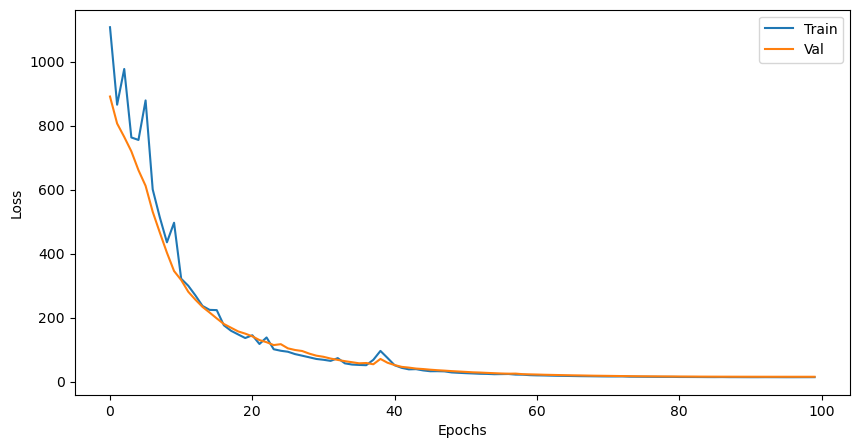

In [766]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [767]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1).cpu()
        labels = labels.cpu()
        
        valid_mask = ~torch.isnan(labels)
        pred_value.append(outputs[valid_mask])
        actual_value.append(labels[valid_mask])

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

import torch.nn.functional as F
mse = F.mse_loss(pred_value, actual_value)
print(f'MSE on test set: {mse.item():.2f}')


C:\Users\ASUS\AppData\Local\Temp\ipykernel_68428\4058220006.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


MSE on test set: 55.02


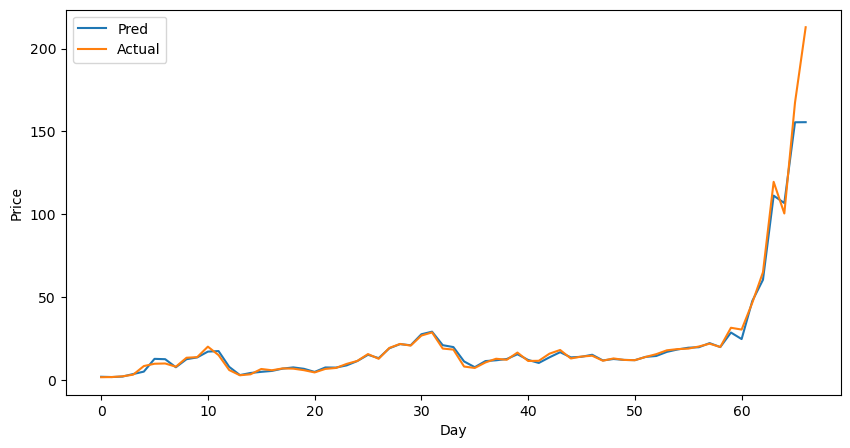

In [768]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:])
plt.plot(actual_value[:])
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()